# Clasificación de Sentimientos Utilizando Naïve Bayes
Realizado por:

Paula Monge
Emmanuel Zúñiga
Trabajo de Invetigación del Curso:

Investigación en Ciencias de la Computación
Tema de Investigación:

Aprendizaje Automático en la clasificación de Sentimientos en Twitter: Comparación de los Algoritmos de LSTM Bidireccional, BERT y Naïve Bayes

# Importación de librerias necesarias 📚

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.1 MB/s eta 0:00:00


In [ ]:
import re
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
from unidecode import unidecode

## Carga del dataset 📅

In [ ]:
# Se carga la libreria drive de google para cargar los archivos almacenados en drive
drive.mount("/content/gdrive")

# El dataset en cuestión contiene datos sobre tweets en diferentes idiomas, pero nos interesa utilizar solo
# los que se encuentran en español.
tweets = pd.read_csv('/content/gdrive/My Drive/tweets.csv').query('Language == "es"')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Visualización de los primeros 10 registros del dataset

In [ ]:
tweets.head(10)

,Text,Language,Label
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
36,"@alitomorenoc No mames, ya mejor lárgate del P...",es,litigious
173,"Good MEWning ♥️🐼♥️\nUn nuevo amanecer,un nuevo...",es,positive
330,criminal por robarme el corazón https://t.co/O...,es,litigious
455,@isiupdates Pantera \n#IsiVives #IsiVivesCHILE...,es,positive
556,Os quiero recordar y hacer saber a los que aún...,es,positive
572,@Orlando71156528 Y sin embargo un criminal de ...,es,litigious
702,@Fergus0055 No sería porque los tóxicos de xbo...,es,positive
812,@loonalendaskk ahh q legal,es,litigious
823,@JesusRCuevas @lopezobrador_ Pues no lamenta l...,es,litigious


## Preprocesamiento y limpieza de datos 🧹

In [ ]:
def remove_emoji(string):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string) 

def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = unidecode(temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_ÑÁÉÍÓÚ]+","", temp)
    temp = re.sub("#","", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-zA-Z0-9ñáéíóú]"," ", temp)
    return temp
    
## Una vez creadas las funciones se procede a realizar la limpieza de los tweets
tweets['Text'] = tweets['Text'].map(lambda x : clean_tweet(x))

In [ ]:
tweets.head(10)

,Text,Language,Label
1,badbunny como dos gotas de agua joven se dis...,es,negative
36,no mames ya mejor largate del pri y deja de ...,es,litigious
173,good mewning un nuevo amanecer un nuevo dia u...,es,positive
330,criminal por robarme el corazon,es,litigious
455,pantera isivives isiviveschile kcamexico,es,positive
556,os quiero recordar y hacer saber a los que aun...,es,positive
572,y sin embargo un criminal de esa calana esta ...,es,litigious
702,no seria porque los toxicos de xbox y hasta s...,es,positive
812,ahh q legal,es,litigious
823,pues no lamenta la muerte de miles de ninos ...,es,litigious


## Creación de datos de entrenamiento y prueba 🏋

Se define una proporción de 80/20 para la creación de los datos de prueba y testeo.

In [ ]:
train_pct = 0.8
train_size = round(len(tweets) * train_pct)

train_data = tweets.iloc[:train_size]
test_data = tweets.iloc[train_size:]

test_data = test_data.drop('Label', axis=1)

In [ ]:
train_data.head(10)

,Text,Language,Label
1,badbunny como dos gotas de agua joven se dis...,es,negative
36,no mames ya mejor largate del pri y deja de ...,es,litigious
173,good mewning un nuevo amanecer un nuevo dia u...,es,positive
330,criminal por robarme el corazon,es,litigious
455,pantera isivives isiviveschile kcamexico,es,positive
556,os quiero recordar y hacer saber a los que aun...,es,positive
572,y sin embargo un criminal de esa calana esta ...,es,litigious
702,no seria porque los toxicos de xbox y hasta s...,es,positive
812,ahh q legal,es,litigious
823,pues no lamenta la muerte de miles de ninos ...,es,litigious


In [ ]:
test_data.head(10)

,Text,Language
753287,1 si 2 maybe 3 no 4 yes 5 paque 6 obvi...,es
753312,somos lindos best,es
753315,en la carcel deberia estar este criminal la d...,es
753423,bad bunny no se equivoco cuando dijo el amor ...,es
753448,te amo question,es
753492,renovacion ha firmado un nuevo contrato de ...,es
753520,vuelvo a la depresion despues de amar y ser de...,es
753633,legal,es
753801,ojala que tuvieran una guerra ideologica con ...,es
753885,yo anhelo que las ffmm retornen su legitimida...,es


## Tokenización de los datos 🔡

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
sample_data = ["This is my first paper", "This is the second document", "here is the third thi one"]

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X = vectorizer.fit_transform(sample_data)

In [ ]:
vectorizer.get_feature_names_out()

array(['document', 'first', 'here', 'is', 'my', 'one', 'paper', 'second',
       'the', 'thi', 'third', 'this'], dtype=object)

In [ ]:
X.toarray()

array([[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]])

In [ ]:
data = train_data['Text'].tolist()

In [ ]:
tweets_countvectorizer = CountVectorizer().fit_transform(data).toarray()

In [ ]:
tweets_countvectorizer.shape

(9066, 24390)

In [ ]:
X = tweets_countvectorizer
y = train_data['Label']

## Implementación de Naïve Bayes para clasificación 🤖

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB #for discrete values

In [ ]:
NB_classifier = MultinomialNB()

In [ ]:
NB_classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = NB_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1322,   14,    7,    4],
       [  57,  146,    5,    0],
       [  71,    4,  133,    0],
       [  33,    3,    4,   11]])

<Axes: >

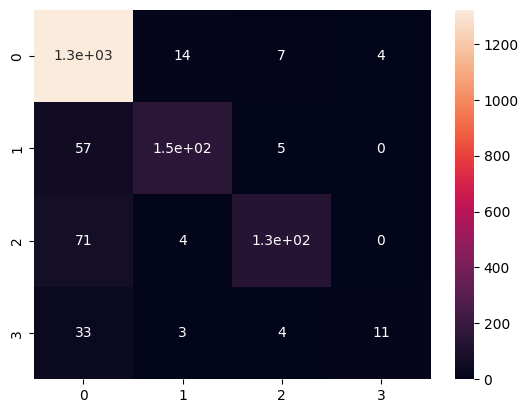

In [ ]:
sns.heatmap(cm, annot = True)

In [ ]:
ac = accuracy_score(y_test, y_pred)
ac

0.8886438809261301

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   litigious       0.89      0.98      0.93      1347
    negative       0.87      0.70      0.78       208
    positive       0.89      0.64      0.75       208
 uncertainty       0.73      0.22      0.33        51

    accuracy                           0.89      1814
   macro avg       0.85      0.63      0.70      1814
weighted avg       0.89      0.89      0.88      1814

